# Introduction

We have taken the Woodbine Horse Racing Results database from Kaggle (https://www.kaggle.com/noqcks/woodbine-races/version/1) and will
be attempting to determine which horse will win a race based on it's characteristics.  

Our process will be to use a sequential NN to classify the winner of a race, then compare the model's accuracy to traditional
machine learning models.


In [3]:
#Imported libraries
import pandas as pd
import numpy as np
import glob
import os
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score

%matplotlib inline
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import pylab as py
import statsmodels.formula.api as smf

# Data Exploration

In [4]:
#Our dataset is only 4k records, with 27 columns
df = pd.read_csv('woodbine_horses.csv')
df.shape

(4370, 27)

In [5]:
print(df.columns)

Index(['track', 'card_id', 'race_date', 'breed', 'name', 'weight', 'age',
       'sex', 'meds_and_equip', 'jockey', 'dollar_odds', 'program_number',
       'post_position', 'claim_price', 'start_position', 'finish_position',
       'finish_time', 'speed_rating', 'trainer', 'owner', 'win_payoff',
       'place_payoff', 'show_payoff', 'weather', 'distance', 'race_type',
       'track_conditions'],
      dtype='object')


In [6]:
#First look at the data
df.head()

,track,card_id,race_date,breed,name,weight,age,sex,meds_and_equip,jockey,...,speed_rating,trainer,owner,win_payoff,place_payoff,show_payoff,weather,distance,race_type,track_conditions
0,WO,D,2015-06-20 00:00:00,TB,Madam Premier,119,4,M,Lb,S Ryan,...,44.0,O'Keefe Thomas,Emily Anne Walker,0.0,0.0,0.0,Cloudy,900.0,Claiming,FT
1,WO,D,2015-07-19 00:00:00,TB,Notion Sonet,118,3,C,L,L Contreras,...,96.0,Carroll Josie,Ivan Dalos,0.0,0.0,0.0,Cloudy,650.0,Allowance,FT
2,WO,D,2015-07-25 00:00:00,TB,Big Red Bugsy,121,5,G,L,S R Bahen,...,83.0,Fournier Mark,"Carruthers, Carruthers, Carruthers, Carruthers...",0.0,0.0,0.0,Cloudy,700.0,Claiming,FT
3,WO,D,2015-08-14 00:00:00,TB,Lillz Pearl,121,5,G,Lb,J McAleney,...,88.0,Singh Ricky,Ricky Singh,0.0,5.7,3.3,Clear,500.0,Allowance,FT
4,WO,D,2015-08-29 00:00:00,TB,Sweet Rose,121,4,F,NaN,L Contreras,...,86.0,Attard Sid C,Stronach Stables,0.0,0.0,3.1,Cloudy,500.0,Allowance,FT


In [7]:
#There's only 1 value for the track feature, making it unnecessary
df['track'].value_counts()

WO     4370
Name: track, dtype: int64

In [8]:
#There's only 1 value for the track feature, making it unnecessary
df['card_id'].value_counts()

D    4370
Name: card_id, dtype: int64

                  values  counts
0    2016-10-16 00:00:00     106
1    2016-09-25 00:00:00      92
2    2016-10-29 00:00:00      89
3    2016-10-09 00:00:00      89
4    2016-09-17 00:00:00      88
..                   ...     ...
200  2016-05-19 00:00:00       1
201  2016-05-15 00:00:00       1
202  2016-05-14 00:00:00       1
203  2016-05-13 00:00:00       1
204  2017-04-05 00:00:00       1

[205 rows x 2 columns]


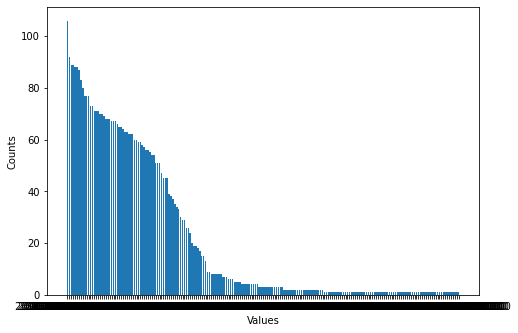

In [16]:
# Checking the values of race date

race_date = df['race_date'].value_counts().rename_axis('values').reset_index(name='counts')
print (race_date)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(race_date['values'],race_date['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

In [29]:
# Another unnecessary column
df['breed'].value_counts()

TB    4370
Name: breed, dtype: int64

                    values  counts
0                Primordia       9
1              Cape Zavata       8
2               Foxy Phill       8
3              Erie Breeze       8
4            Buckden House       8
...                    ...     ...
1595  dq-Too Many Egbert's       1
1596          Nezwaah (GB)       1
1597         Bangla Dancer       1
1598          Uncle Shaggy       1
1599            My Cantata       1

[1600 rows x 2 columns]


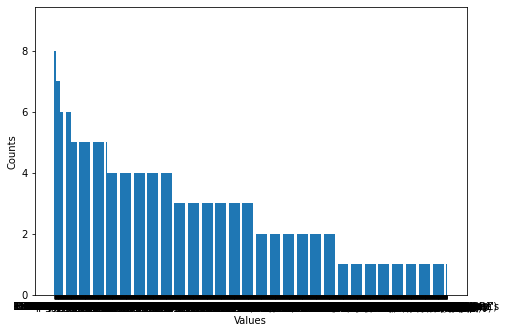

In [18]:
# This feature appears to be the name of the horse

name = df['name'].value_counts().rename_axis('values').reset_index(name='counts')
print (name)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(name['values'],name['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0      119    1119
1      121    1064
2      118     587
3      120     417
4        0     317
5      117     237
6      123     198
7      116     162
8      115     100
9      114      83
10     122      44
11     124      15
12     113      13
13     126      12
14     112       1
15     109       1


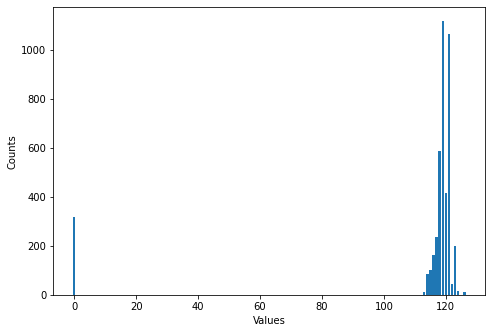

In [26]:
# Weight - Around 300 records keep appearing with null values, these will need to be cleaned

weight = df['weight'].value_counts().rename_axis('values').reset_index(name='counts')
print (weight)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(weight['values'],weight['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0        3    1181
1        4    1023
2        2     674
3        5     562
4        6     331
5        0     317
6        7     208
7        8      44
8        9      23
9       10       4
10      11       3


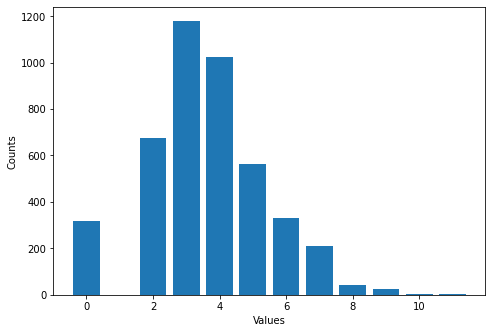

In [27]:
# Age of the horse

age = df['age'].value_counts().rename_axis('values').reset_index(name='counts')
print (age)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age['values'],age['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

  values  counts
0      G    1824
1      F    1060
2      M     853
3      C     184
4      H     111
5      R      21


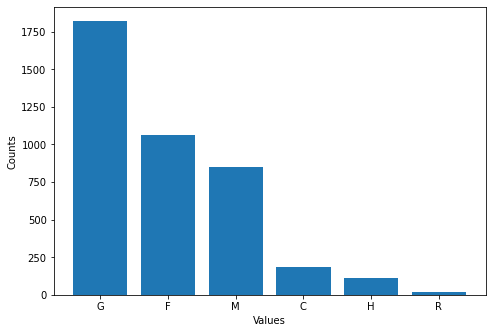

In [28]:
# Sex of the horse

sex = df['sex'].value_counts().rename_axis('values').reset_index(name='counts')
print (sex)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sex['values'],sex['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

   values  counts
0      Lb    1709
1       L    1533
2     Lbf     243
3      Lf     213
4       b     131
5      Ly      14
6      Lv      13
7       y      10
8      bf       8
9     Lby       6
10      f       5
11    Lvf       5
12    Lfy       5
13     by       4
14      v       4
15   Lbfy       1
16    bfy       1
17   Lbfr       1
18    Lbr       1


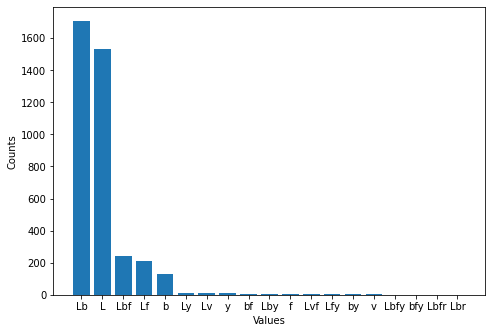

In [29]:
# meds and equipment, after some research this is something typically tracked for the horse

meds_and_equip = df['meds_and_equip'].value_counts().rename_axis('values').reset_index(name='counts')
print (meds_and_equip)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(meds_and_equip['values'],meds_and_equip['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

           values  counts
0    E R Da Silva     285
1   R M Hernandez     284
2   L   Contreras     258
3   G   Boulanger     249
4       D   Moran     240
..            ...     ...
81      W T Buick       1
82    C P DeCarlo       1
83     O   Murphy       1
84    P   Morales       1
85     H F Newell       1

[86 rows x 2 columns]


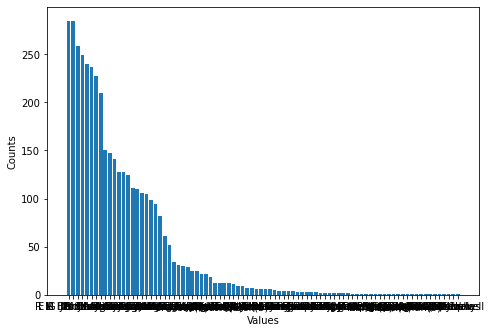

In [30]:
# Jockey

jockey = df['jockey'].value_counts().rename_axis('values').reset_index(name='counts')
print (jockey)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(jockey['values'],jockey['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

      values  counts
0       0.00     319
1       2.65      26
2       3.00      25
3       2.80      24
4       2.20      22
...      ...     ...
1207   79.35       1
1208  158.15       1
1209   19.20       1
1210   76.35       1
1211   25.40       1

[1212 rows x 2 columns]


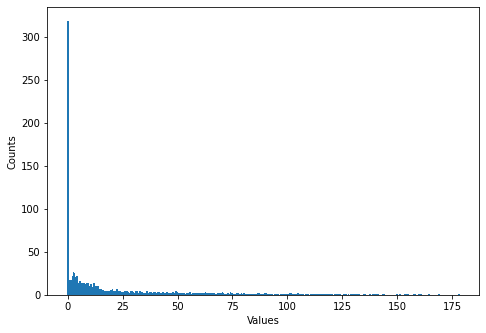

In [32]:
# Dollar odds

dollar_odds = df['dollar_odds'].value_counts().rename_axis('values').reset_index(name='counts')
print (dollar_odds)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(dollar_odds['values'],dollar_odds['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0      5.0     446
1      2.0     443
2      1.0     436
3      4.0     435
4      3.0     433
5      6.0     430
6      7.0     383
7      8.0     323
8      9.0     240
9     10.0     161
10    11.0     121
11    12.0      90
12    13.0      55
13    14.0      42
14    15.0      10
15    16.0       5


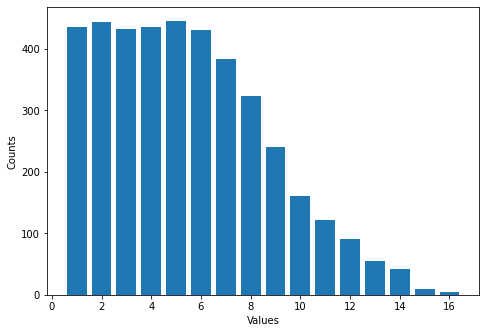

In [33]:
# Program number

feature = df['program_number'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0        1     461
1        2     459
2        3     457
3        4     455
4        5     454
5        6     448
6        7     383
7        0     317
8        8     313
9        9     228
10      10     144
11      11     107
12      12      78
13      13      40
14      14      26


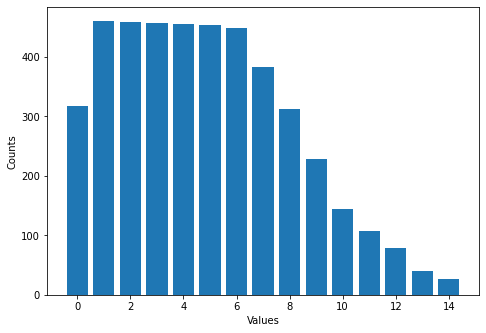

In [37]:
# Post position

feature = df['post_position'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

In [39]:
# claim_price

feature = df['claim_price'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

    values  counts
0        0    1859
1     9500     475
2    20000     270
3    10000     264
4    40000     245
5     7500     172
6    19000     135
7     8000     121
8     6000     110
9    37500     105
10   12500      87
11   25000      85
12   11500      82
13   32000      67
14   16000      64
15   15000      54
16    6250      45
17   30000      33
18   60000      30
19   62500      20
20   23500      20
21   75000      12
22   50000       9
23   47500       4
24   72500       1
25   80000       1


    values  counts
0      1.0     464
1      3.0     458
2      4.0     456
3      2.0     451
4      5.0     438
5      6.0     432
6      0.0     409
7      7.0     373
8      8.0     300
9      9.0     211
10    10.0     139
11    11.0     102
12    12.0      72
13    13.0      39
14    14.0      26


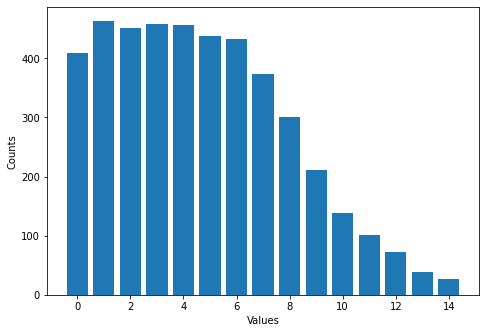

In [40]:
# start position

feature = df['start_position'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0      3.0     470
1      2.0     466
2      1.0     464
3      4.0     457
4      5.0     454
5      6.0     444
6      7.0     383
7      0.0     317
8      8.0     305
9      9.0     227
10    10.0     139
11    11.0     104
12    12.0      73
13    13.0      41
14    14.0      26


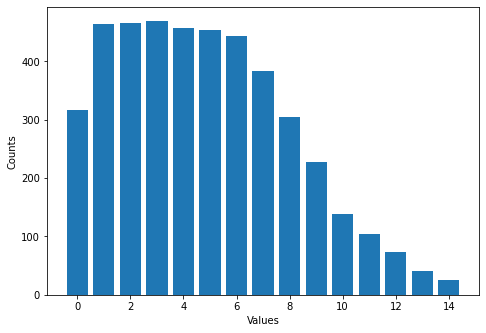

In [41]:
feature = df['finish_position'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

In [21]:
#Unnecessary feature
df['finish_time'].value_counts()

0.0    4053
Name: finish_time, dtype: int64

     values  counts
0      68.0     119
1      80.0     117
2      72.0     113
3      69.0     112
4      75.0     111
..      ...     ...
113    22.0       1
114    19.0       1
115    17.0       1
116    27.0       1
117   107.0       1

[118 rows x 2 columns]


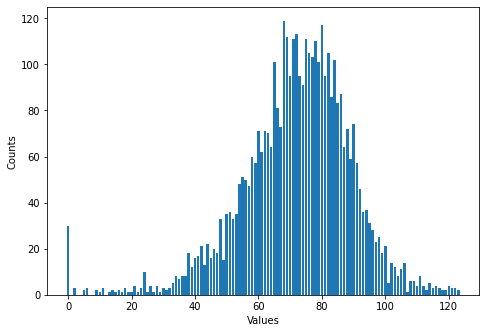

In [42]:
# So far this is the only feature showing what looks like a normal distribution.  Those ~30 value counts of 0 are likely null values
# Speed rating

feature = df['speed_rating'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

                 values  counts
0          Casse Mark E     158
1          Attard Kevin     106
2    De Paulo Michael P      98
3       McKnight Norman      94
4       Doyle Michael J      88
..                  ...     ...
280  Benson Liam Daniel       1
281     Connelly Teresa       1
282     Hickst Waldemar       1
283     Concessi Armand       1
284        Smith Andrew       1

[285 rows x 2 columns]


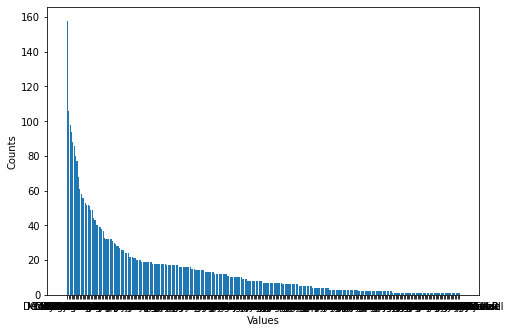

In [43]:
# trainer

feature = df['trainer'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

                                           values  counts
0                                 Colebrook Farms      62
1                               Bruno Schickedanz      58
2                          Joey Gee Thoroughbreds      47
3                                   Tucci Stables      45
4                               Chiefswood Stable      45
..                                            ...     ...
859                              Silver King Farm       1
860  Sheikh Ahmed Al Maktoum Lessee and Godolphin       1
861                             Golden Eagle Farm       1
862               Ramsey, Kenneth L. and Sarah K.       1
863                           JMC's Racing Stable       1

[864 rows x 2 columns]


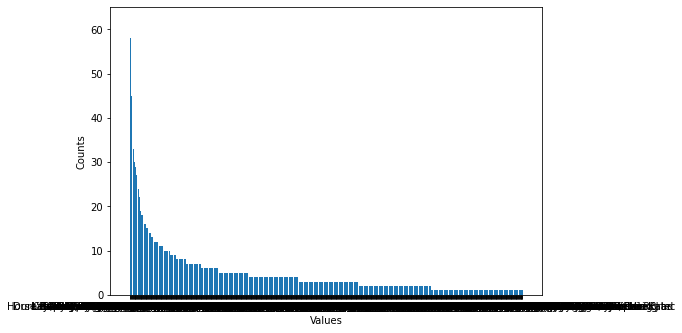

In [44]:
# Owner
feature = df['owner'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

     values  counts
0       0.0    3906
1       5.5       9
2       6.5       9
3       4.7       8
4       5.7       8
..      ...     ...
189    46.0       1
190    44.8       1
191    35.8       1
192    14.0       1
193    19.5       1

[194 rows x 2 columns]


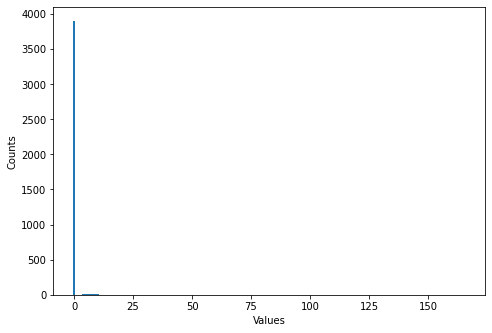

In [45]:
# Win payoff

feature = df['win_payoff'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

     values  counts
0       0.0    3440
1       3.0      29
2       2.9      29
3       3.6      28
4       3.3      26
..      ...     ...
152    14.8       1
153    25.8       1
154    22.3       1
155    14.7       1
156    27.7       1

[157 rows x 2 columns]


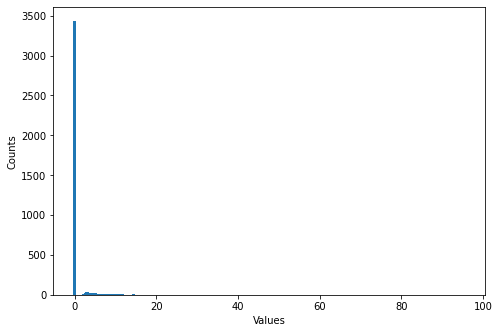

In [46]:
# Place payoff

feature = df['place_payoff'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

     values  counts
0       0.0    2994
1       2.1      83
2       2.9      61
3       2.8      59
4       2.6      57
..      ...     ...
112    11.1       1
113    12.9       1
114    19.8       1
115    14.6       1
116    44.9       1

[117 rows x 2 columns]


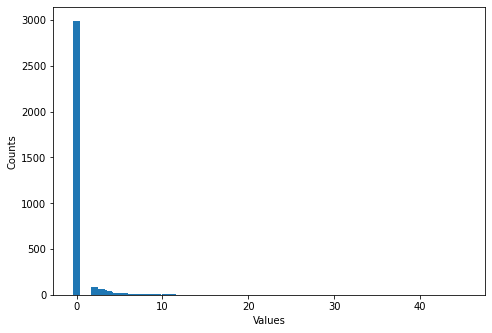

In [47]:
# show payoff

feature = df['show_payoff'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0   Cloudy    3145
1  Showery     544
2    Clear     425
3    Rainy     231
4  Snowing      25


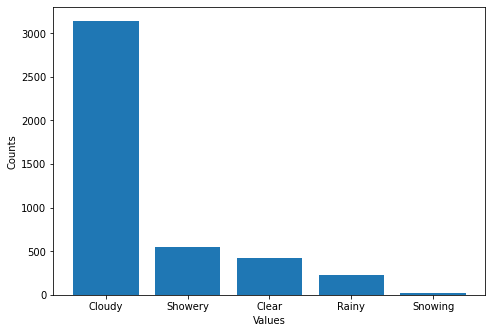

In [48]:
# weather 

feature = df['weather'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

    values  counts
0    850.0    1083
1    600.0     920
2    700.0     788
3    650.0     525
4    500.0     386
5    900.0     343
6    800.0     152
7    550.0      78
8   1000.0      39
9   1200.0      25
10  1400.0      14
11  1500.0       9
12  1300.0       8


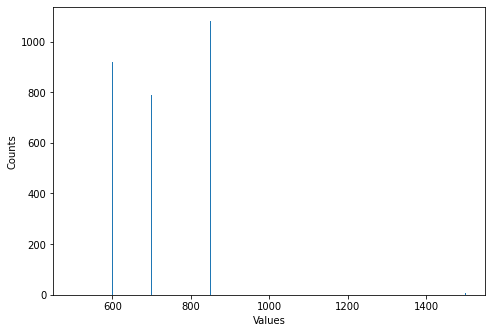

In [49]:
# Distance, assuming this is the distance of the race

feature = df['distance'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

                        values  counts
0                     Claiming    1756
1              Maiden Claiming     797
2                    Allowance     600
3        Maiden Special Weight     424
4                       Stakes     365
5  Allowance Optional Claiming     188
6     Maiden Optional Claiming     140
7           Starters Allowance      85
8            Optional Claiming      15


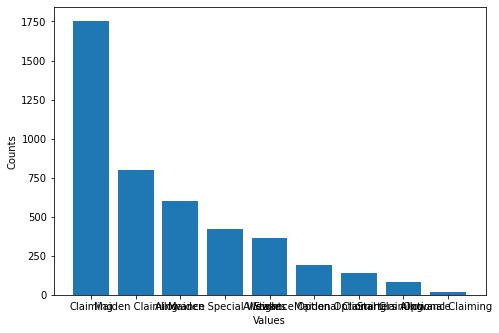

In [50]:
# race type
feature = df['race_type'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

  values  counts
0     FT    3771
1     GD     340
2     FM     252
3     YL       7


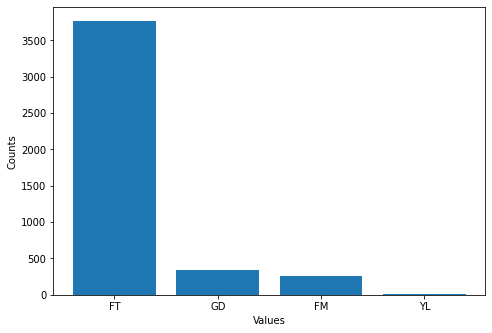

In [51]:
# Track conditions

feature = df['track_conditions'].value_counts().rename_axis('values').reset_index(name='counts')
print (feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature['values'],feature['counts'])
ax.set_ylabel('Counts')
ax.set_xlabel('Values')
plt.show()

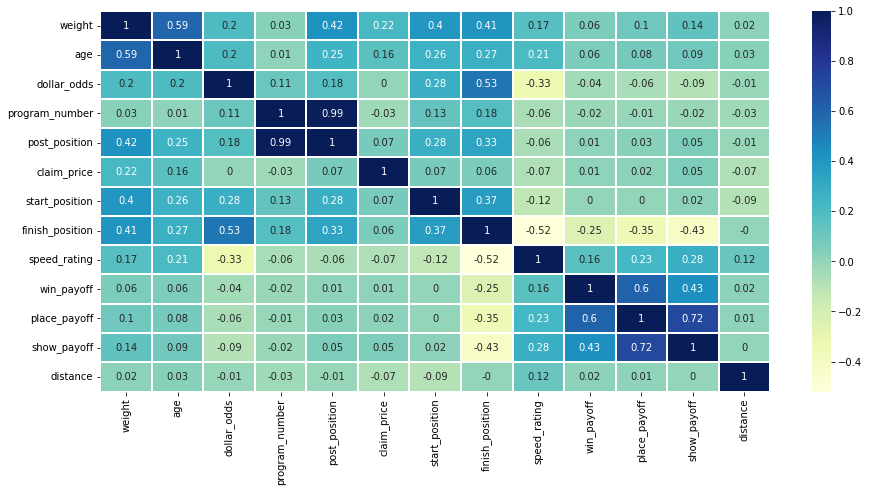

In [32]:
heatmap_columns = df.drop(['race_date','track', 'card_id', 'breed', 'finish_time'], axis=1)
matrix = heatmap_columns.corr().round(2)
f, ax = plt.subplots(figsize =(15, 7))
sns.heatmap(matrix, annot=True,linewidths = 0.1,cmap ="YlGnBu")
plt.show()

#Lets see the correlation between features in our dataset

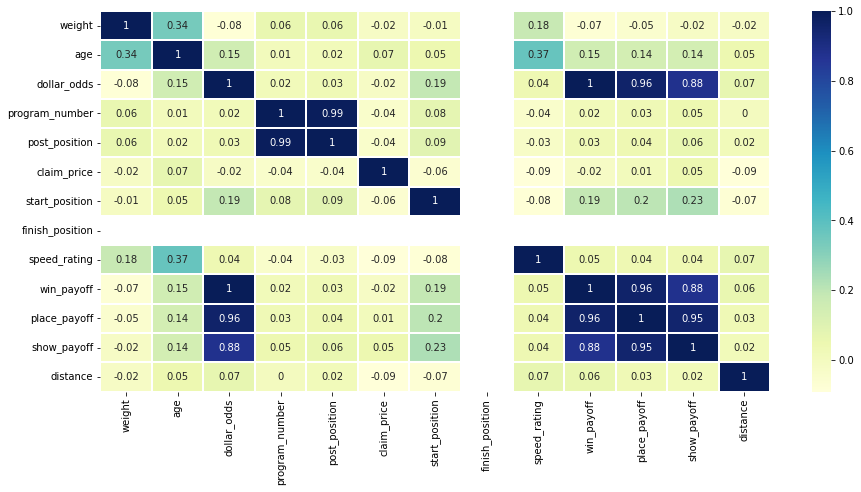

In [33]:
#Lets see the correlation between features in our dataset, only for the winners, or finish position 1

heatmap_columns2 = df.drop(['race_date','track', 'card_id', 'breed', 'finish_time'], axis=1)
heatmap_columns2 = heatmap_columns[heatmap_columns.apply(lambda x: x["finish_position"] == 1, axis=1)]
matrix = heatmap_columns2.corr().round(2)
f, ax = plt.subplots(figsize =(15, 7))
sns.heatmap(matrix, annot=True,linewidths = 0.1,cmap ="YlGnBu")
plt.show()

3234.5166666666664

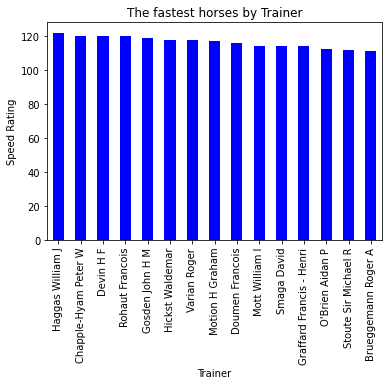

In [34]:
# Some investigation to try and figure out what the speed rating factor is

fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('trainer').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('The fastest horses by Trainer')
plt.xlabel('Trainer') 
plt.ylabel('Speed Rating')

df.groupby('trainer').mean()['speed_rating'].sort_values(ascending=False).head(30).sum()

749.9143600431051

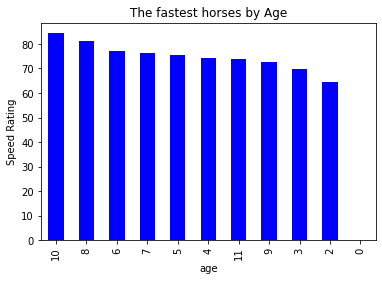

In [35]:
# Some interesting data on horses comparing age with speed

fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('age').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('The fastest horses by Age')
plt.xlabel('age') 
plt.ylabel('Speed Rating')

df.groupby('age').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

#It looks like horses more experience are faster, and the preferable range of ages are from 7 to 10 year, when horses start to decrease performance

909.0339789969942

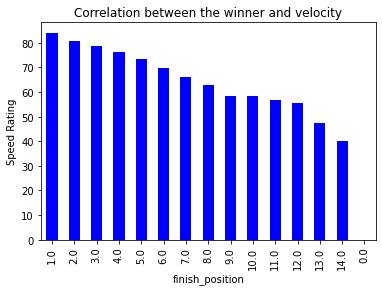

In [36]:
# As we can see, the fastest horse is always the winner.

fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('finish_position').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('Correlation between the winner and velocity')
plt.xlabel('finish_position') 
plt.ylabel('Speed Rating')

df.groupby('finish_position').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

1120.7705220738842

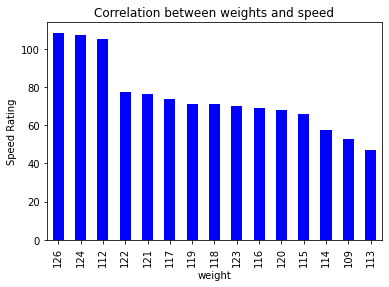

In [37]:
#It looks like the weight is really important for the wiinner, as the weightest horses are also the fastest ones, whith some small exceptions.

fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('weight').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('Correlation between weights and speed')
plt.xlabel('weight') 
plt.ylabel('Speed Rating')

df.groupby('weight').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()



# Data Cleaning

In [52]:
#First step is to remove all unnecessary columns with no information
df = df.drop(['track', 'card_id', 'breed', 'finish_time'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4370 non-null   object 
 1   name              4370 non-null   object 
 2   weight            4370 non-null   int64  
 3   age               4370 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4370 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4370 non-null   int64  
 10  claim_price       4370 non-null   int64  
 11  start_position    4370 non-null   float64
 12  finish_position   4370 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4370 non-null   float64


In [53]:
# The meds and equipment feature is missing some values.  Looked up what this code means from woodbine's horse program,
# and 'L' represents no equipment.  Changed all Nulls to L'''
df['meds_and_equip'].fillna(value='L')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4370 non-null   object 
 1   name              4370 non-null   object 
 2   weight            4370 non-null   int64  
 3   age               4370 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4370 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4370 non-null   int64  
 10  claim_price       4370 non-null   int64  
 11  start_position    4370 non-null   float64
 12  finish_position   4370 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4370 non-null   float64


In [54]:
# Upon review there are numerous records with missing values, these records only include basic information like the horses name
# making them unsuitable for our model
df.dropna(subset = ["trainer"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  finish_position   4053 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4053 non-null   float64


In [55]:
#Created my features and label
Y = df[['finish_position']]
X = df.drop(['finish_position'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  speed_rating      4053 non-null   float64
 13  trainer           4053 non-null   object 
 14  owner             4053 non-null   object 
 15  win_payoff        4053 non-null   float64
 16  place_payoff      4053 non-null   float64


In [56]:
#One hot encoded all categorical features 

encoder = LabelEncoder()
encoder.fit(X['race_date'])
X['race_date'] = encoder.transform(X['race_date'])

#Creating dummies for categorical names
X_dummies = pd.get_dummies(X[['name']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('name', axis=1, inplace=True)

#Creating dummies for categorical sex
X_dummies = pd.get_dummies(X[['sex']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('sex', axis=1, inplace=True)

#Creating dummies for meds and equipment
X_dummies = pd.get_dummies(X[['meds_and_equip']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('meds_and_equip', axis=1, inplace=True)

#Creating dummies for jockey
X_dummies = pd.get_dummies(X[['jockey']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('jockey', axis=1, inplace=True)

#Creating dummies for trainer
X_dummies = pd.get_dummies(X[['trainer']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('trainer', axis=1, inplace=True)

#Creating dummies for owner
X_dummies = pd.get_dummies(X[['owner']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('owner', axis=1, inplace=True)

#Creating dummies for weather
X_dummies = pd.get_dummies(X[['weather']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('weather', axis=1, inplace=True)

#Creating dummies for race type
X_dummies = pd.get_dummies(X[['race_type']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('race_type', axis=1, inplace=True)

#Creating dummies for track conditions
X_dummies = pd.get_dummies(X[['track_conditions']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('track_conditions', axis=1, inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Columns: 2855 entries, race_date to track_conditions_YL
dtypes: float64(8), int32(1), int64(4), uint8(2842)
memory usage: 11.4 MB


In [57]:
#Merged all the non-winning horses to a single category, we will only be predicting first place
Y['finish_position'] = np.where(Y['finish_position'] > 1, 2, Y['finish_position'])
Y = Y.astype(str)
Y_dummies = pd.get_dummies(Y[['finish_position']])
Y = pd.concat([Y,Y_dummies], axis=1)
Y.drop('finish_position', axis=1, inplace=True)
Y.head()

C:\Users\Mike\AppData\Local\Temp/ipykernel_9364/263452758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['finish_position'] = np.where(Y['finish_position'] > 1, 2, Y['finish_position'])


,finish_position_1.0,finish_position_2.0
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [58]:
#The next step is to standardize our data (changing the values to between 0 and 1)
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [60]:
X.shape

(4053, 2855)

# Model Building

### Highest Accuracy Model

In [31]:
#Train and test splitting the data
train_x, test_x, train_y, test_y = model_selection.train_test_split(X,Y,test_size = 0.2, random_state = 0)

In [32]:
model = keras.Sequential(
    [
        layers.Dense(5000, activation='sigmoid', name='layer1'),
        layers.Dropout(0.2),
        layers.Dense(1000, activation='relu', name='layer2'),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dense(40, activation='relu', name='layer4'),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

In [13]:
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0, clipvalue=0.5, name="Adam")

In [33]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [39]:
#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horserace.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.3165 - val_accuracy: 0.9457

Epoch 00001: val_accuracy improved from -inf to 0.94575, saving model to weights.hdf5
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.4385 - val_accuracy: 0.9433

Epoch 00002: val_accuracy did not improve from 0.94575
Epoch 3/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.5182 - val_accuracy: 0.9346

Epoch 00003: val_accuracy did not improve from 0.94575
Epoch 4/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.2686 - val_accuracy: 0.9383

Epoch 00004: val_accuracy did not improve from 0.94575
Epoch 5/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.4098 - val_accuracy: 0.9457

Epoch 00005: val_accuracy did

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 5000)              14280000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 5000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 1000)              5001000   
_________________________________________________________________
layer3 (Dense)               (None, 200)               200200    
_________________________________________________________________
layer4 (Dense)               (None, 40)                8040      
_________________________________________________________________
output1 (Dense)              (None, 2)                 82        
Total params: 19,489,322
Trainable params: 19,489,322
Non-trainable params: 0
__________________________________________

In [41]:
# %% Predictions

y_pred = model.predict(test_x)



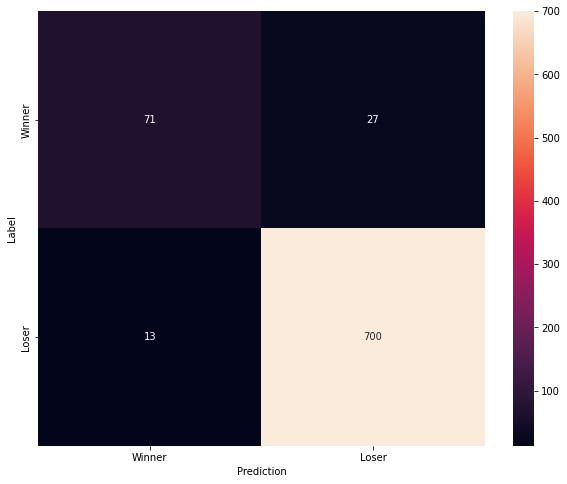

In [42]:
%matplotlib inline
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

pred = y_pred.argmax(axis=1)
labels = test_y.values.argmax(axis=1)
title = np.array(['Winner', 'Loser'])

confusion_mtx = tf.math.confusion_matrix(labels, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=title,
            yticklabels=title,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [43]:
print("\nHistory Keys:\n")
print(history.history.keys())



History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Recall from NN model: 0.8531284884220167
Precision from NN model: 0.9040495840702167


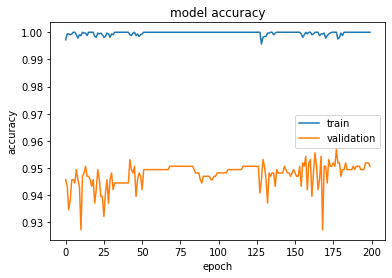

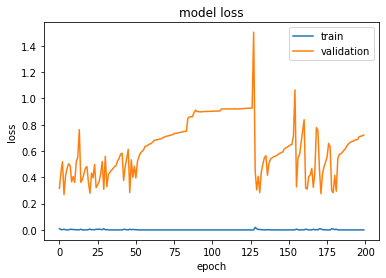

In [44]:
recall = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 1)
precision = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 0)  
print('Recall from NN model:', np.mean(recall))
print('Precision from NN model:', np.mean(precision)) 

plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [54]:
# Our final validation accuracy is 0.95314, but the smoothness of our learning rate and fluctuation of our loss is undesirable

# Hyperparameter Tuning

We tried different hyperparameters to try and increase our accuracy, this is a list of all the hyperparamenters we tuned:
    
    - changing the optimizer
    - adding and removing dropout layers
    - adding and removing dense layers, including the number of nodes
    - changing our activation functions
    - changing our final layer between softmax and sigmoid
    - attempting batch normalization

### Model 2

In [55]:
#This is an example of our model where we changed the optimizer, changing adam's default values

model2 = keras.Sequential(
    [
        layers.Dense(1400, activation='sigmoid', name='layer1'),
        layers.Dense(700, activation='relu', name='layer2'),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dense(20, activation='relu', name='layer4'),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
model2.compile(loss = 'categorical_crossentropy' , optimizer = optimizer2 , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv2.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model2.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horseracev2.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3957 - accuracy: 0.8482 - val_loss: 0.3680 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv2.hdf5
Epoch 2/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3516 - accuracy: 0.8871 - val_loss: 0.3683 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3525 - accuracy: 0.8871 - val_loss: 0.3678 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3513 - accuracy: 0.8871 - val_loss: 0.3737 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3518 - accuracy: 0.8871 - val_loss: 0.3666 - val_accuracy: 0.87920s - loss: 0.3543 - accuracy:

In [56]:
y_pred2 = model2.predict(test_x)

In [57]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [58]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1400)              3998400   
_________________________________________________________________
layer2 (Dense)               (None, 700)               980700    
_________________________________________________________________
layer3 (Dense)               (None, 200)               140200    
_________________________________________________________________
layer4 (Dense)               (None, 20)                4020      
_________________________________________________________________
output1 (Dense)              (None, 2)                 42        
Total params: 5,123,362
Trainable params: 5,123,362
Non-trainable params: 0
_________________________________________________________________


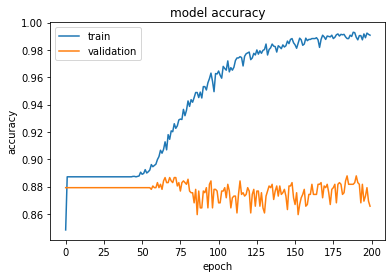

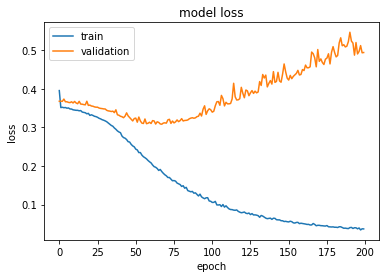

In [59]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we can see, there is fluctuation in our validation accuracy but no improvement

### Model 3

In [61]:
#Variation 3, this model attempted to add many dropout layers

model3 = keras.Sequential(
    [
        layers.Dense(1400, activation='sigmoid', name='layer1'),
        layers.Dropout(0.2),
        layers.Dense(700, activation='relu', name='layer2'),
        layers.Dropout(0.2),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dropout(0.2),
        layers.Dense(20, activation='relu', name='layer4'),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

model3.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv2.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model3.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horseracev3.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 8ms/step - loss: 0.4456 - accuracy: 0.8717 - val_loss: 0.3758 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv2.hdf5
Epoch 2/200
102/102 [==============================] - 0s 5ms/step - loss: 0.4046 - accuracy: 0.8865 - val_loss: 0.3679 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3761 - accuracy: 0.8871 - val_loss: 0.3625 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3721 - accuracy: 0.8868 - val_loss: 0.3607 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8871 - val_loss: 0.3493 - val_accuracy: 0.8792

Epoch 00005: val_accuracy d

In [62]:
y_pred2 = model3.predict(test_x)

In [63]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [64]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1400)              3998400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1400)              0         
_________________________________________________________________
layer2 (Dense)               (None, 700)               980700    
_________________________________________________________________
dropout_6 (Dropout)          (None, 700)               0         
_________________________________________________________________
layer3 (Dense)               (None, 200)               140200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
layer4 (Dense)               (None, 20)               

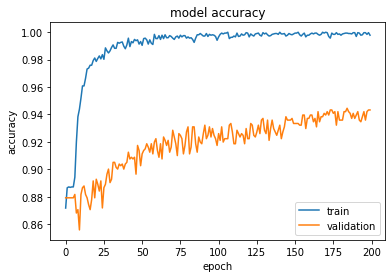

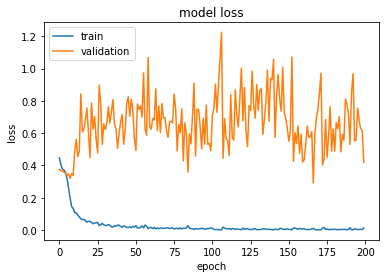

In [65]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we see overfitting in the previous model, we tried to increase even more our number of epochs to 200, and also we tried to add Dropouts to avoid a possible overfitting
# for this trial, the accuracyhas dropped slighly

In [ ]:
# Adding more dropout layers ultimately didn't help our overall accuracy, with slightly superior performance with less dropouts

### Model 4

In [16]:
#In this attempt we tried a kernel regularization of l2 for batch normalization

model4 = keras.Sequential(
    [
        layers.Dense(2000, activation='sigmoid', name='layer1', kernel_regularizer='l2'), #addin kernel regularizer to try to decrease overfitting
        tf.keras.layers.BatchNormalization(), # this is batch normalization, another technique for improve overfiting training sets
        layers.Dropout(0.2),
        layers.Dense(1000, activation='relu', name='layer2', kernel_regularizer='l2',kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        layers.Dense(300, activation='relu', name='layer3', kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),
        layers.Dense(50, activation='relu', name='layer4', kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),     
        layers.Dense(2, activation='softmax', name='output1', kernel_regularizer='l2'),
    ]
)
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0, clipvalue=0.5)
model4.compile(loss = 'categorical_crossentropy' , optimizer = optimizer , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv4.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model4.fit(
                    train_x, 
                    train_y, 
                    epochs=300,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y), verbose=2
                    )

model_name = "horseracev4.h5"
model.save(model_name)

Epoch 1/300
102/102 - 3s - loss: 14.6761 - accuracy: 0.7239 - val_loss: 2.0816 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv4.hdf5
Epoch 2/300
102/102 - 2s - loss: 1.3344 - accuracy: 0.8732 - val_loss: 1.0074 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/300
102/102 - 2s - loss: 0.8884 - accuracy: 0.8800 - val_loss: 0.8299 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/300
102/102 - 2s - loss: 0.7788 - accuracy: 0.8831 - val_loss: 0.8030 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/300
102/102 - 2s - loss: 0.6408 - accuracy: 0.8954 - val_loss: 0.8041 - val_accuracy: 0.8792

Epoch 00005: val_accuracy did not improve from 0.87916
Epoch 6/300
102/102 - 2s - loss: 0.6495 - accuracy: 0.8942 - val_loss: 0.7361 - val_accuracy: 0.8816

Epoch 00006: val_accuracy improved from 0.87916 to 0.88163, saving model to wei

In [17]:
y_pred4 = model4.predict(test_x)

In [18]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 2000)              5712000   
_________________________________________________________________
batch_normalization (BatchNo (None, 2000)              8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 1000)              2001000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
layer3 (Dense)               (None, 300)               300300    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)              

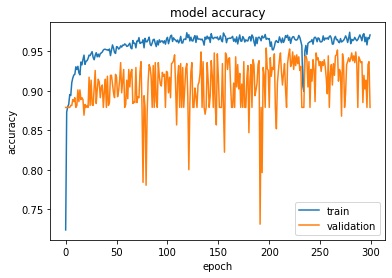

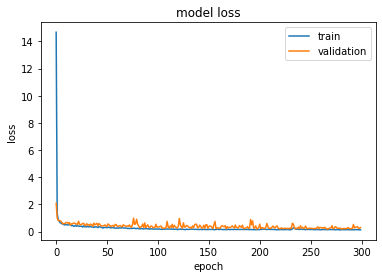

In [20]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
#The final validation accuracy is comparable to our final model, but the large fluctuations in validation accuracy are undesirable.
#The model appears to struggle to learn fluctuates around a lower mean validation accuracy

# Comparison to Traditional ML Models

In [71]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [72]:
#For traditional ML models we'll need only 1 array of values, 1st place of not.
Y_ml = Y['finish_position_1.0']

In [73]:
# Training test split for machine learning algorithm
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(X,Y_ml,test_size = 0.2, random_state = 1)

In [92]:
#Random Forest Classifier
model3 = RandomForestClassifier(max_depth=10)
model3.fit(train_X, train_Y)
y_pred = model3.predict(test_X)
cm3 = confusion_matrix(y_pred, test_Y)
total3=sum(sum(cm3))
Accuracy = (cm3[0,0]+cm3[1,1])/total4
Specificity = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print("Accuracy of  RFC :", Accuracy, "--Specificity of  RFC :", Specificity )

Accuracy of  RFC : 0.8914919852034525 --Specificity of  RFC : 0.8914919852034525


In [94]:
#SVM Classifier
model4 = SVC(kernel='rbf')
model4.fit(train_X, train_Y)
y_pred = model4.predict(test_X)
cm4 = confusion_matrix(y_pred, test_Y)
total4=sum(sum(cm4))
Accuracy = (cm4[0,0]+cm4[1,1])/total4
Specificity = cm4[0,0]/(cm4[0,0]+cm4[0,1])
print("Accuracy of  SVM :", Accuracy, "--Specificity of  SVM :", Specificity )


Accuracy of  SVM : 0.8914919852034525 --Specificity of  SVM : 0.8914919852034525


In [81]:
#  GaussianNB 
model5 = GaussianNB()
model5.fit(train_X, train_Y)
y_pred = model5.predict(test_X)
cm5 = confusion_matrix(y_pred, test_Y)
total5=sum(sum(cm5))
Accuracy = (cm5[0,0]+cm5[1,1])/total5
    
Specificity = cm5[0,0]/(cm5[0,0]+cm5[0,1])
Sensitivity = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print("Accuracy of  GaussianNB :", Accuracy, "--Sensitivity of  GaussianNB :", Sensitivity, "--Specificity of  GaussianNB :", Specificity )


Accuracy of  GaussianNB : 0.6905055487053021 --Sensitivity of  GaussianNB : 0.12442396313364056 --Specificity of  GaussianNB : 0.8973063973063973


In [82]:
model6 = KNeighborsClassifier(n_neighbors=3)

model6.fit(train_X, train_Y)
 
# making predictions on the testing set
y_pred = model6.predict(test_X)
cm6 = confusion_matrix(y_pred, test_Y)
total6=sum(sum(cm6))
Accuracy = (cm6[0,0]+cm6[1,1])/total6
Specificity= cm6[0,0]/(cm6[0,0]+cm6[0,1])
Sensitivity = cm6[1,1]/(cm6[1,0]+cm6[1,1])
print("Accuracy of KNN:", Accuracy, "--Sensitivity of KNN:", Sensitivity, "--Specificity of KNN:", Specificity )

Accuracy of KNN: 0.8692971639950678 --Sensitivity of KNN: 0.2631578947368421 --Specificity of KNN: 0.8990944372574385


Our NN model has superior accuracy to all ML models

    -NN:   0.95314
    -RFC:  0.89149
    -SVMC: 0.89149
    -KNNC: 0.86929
    -GNB:  0.69050